In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from Dataloader import prepare_data_loader
from Models import ConvAutoencoder

In [11]:
# training_data_dir = './data/lunar/training/data/S12_GradeA/'
# training_labels_file = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'

# train_loader = prepare_data_loader(overlap=0.25, window_length=1, decimation_factor=3, spect_nfft=128, spect_nperseg=128, batch_size=128, data_dir = training_data_dir, labels_file_path=training_labels_file)

In [12]:
training_data_dir = "./data/seismic_autoencoder_data/"
training_labels_file = (
    "./data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
)

# training_data_dir = './data/apollo/'
autoencoder_loader = prepare_data_loader(
    overlap=0.25,
    window_length=1,
    decimation_factor=3,
    spect_nfft=128,
    spect_nperseg=128,
    batch_size=128,
    data_dir=training_data_dir,
    labels_file_path=training_labels_file,
)

Starting number of files: 139
Number of uniques files: 123
xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed
xa.s12.00.mhz.1970-03-25HR00_evid00003.mseed
xa.s12.00.mhz.1970-03-26HR00_evid00004.mseed
xa.s12.00.mhz.1970-04-25HR00_evid00006.mseed
xa.s12.00.mhz.1970-04-26HR00_evid00007.mseed
xa.s12.00.mhz.1970-06-15HR00_evid00008.mseed
xa.s12.00.mhz.1970-06-26HR00_evid00009.mseed
xa.s12.00.mhz.1970-07-20HR00_evid00010.mseed
xa.s12.00.mhz.1970-09-26HR00_evid00013.mseed
xa.s12.00.mhz.1970-10-24HR00_evid00014.mseed
xa.s12.00.mhz.1970-11-12HR00_evid00015.mseed
xa.s12.00.mhz.1970-12-11HR00_evid00017.mseed
xa.s12.00.mhz.1970-12-27HR00_evid00019.mseed
xa.s12.00.mhz.1970-12-31HR00_evid00021.mseed
xa.s12.00.mhz.1971-01-15HR00_evid00022.mseed
xa.s12.00.mhz.1971-01-28HR00_evid00023.mseed
xa.s12.00.mhz.1971-01-29HR00_evid00024.mseed
xa.s12.00.mhz.1971-02-09HR00_evid00026.mseed
xa.s12.00.mhz.1971-03-25HR00_evid00028.mseed
xa.s12.00.mhz.1971-04-13HR02_evid00029.mseed
xa.s12.00.mhz.1971-04-17HR00_evid00030.ms

In [14]:
model = ConvAutoencoder(hidden_size=100)

# load model
# model.load_state_dict(torch.load('./models/encoder.pth'))

In [15]:
height, width = autoencoder_loader.dataset.tensors[0].shape[1:]

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


ConvAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 3, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(3, 2, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=480, out_features=100, bias=True)
    (relu): ReLU()
    (tanh): Tanh()
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(2, 3, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(3, 1, kernel_size=(4, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (relu): ReLU()
    (fc1): Linear(in_features=100, out_features=480, bias=True)
  )
)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the loss functions and optimizer
criterion_recon = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the autoencoder
num_epochs = 200
for epoch in range(num_epochs):
    epoch_recon_loss = 0

    for x_data in autoencoder_loader:
        x_data = x_data[0].reshape(-1, 1, height, width).to(device)

        optimizer.zero_grad()

        # Forward pass through the model
        recon = model(x_data)
        embd_space = model.encoder(x_data)

        recon_loss = criterion_recon(recon, x_data)

        recon_loss.backward()
        optimizer.step()

        epoch_recon_loss += recon_loss.item()

    if epoch % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Recon Loss: {epoch_recon_loss:.4f}")

Epoch [1/200], Recon Loss: 47.6949
Epoch [6/200], Recon Loss: 42.4555
Epoch [11/200], Recon Loss: 39.6665
Epoch [16/200], Recon Loss: 38.1421
Epoch [21/200], Recon Loss: 37.9768
Epoch [26/200], Recon Loss: 38.9054
Epoch [31/200], Recon Loss: 39.0422
Epoch [36/200], Recon Loss: 37.5877
Epoch [41/200], Recon Loss: 38.2429
Epoch [46/200], Recon Loss: 37.8121
Epoch [51/200], Recon Loss: 37.1964
Epoch [56/200], Recon Loss: 37.1385
Epoch [61/200], Recon Loss: 37.2000
Epoch [66/200], Recon Loss: 37.2266
Epoch [71/200], Recon Loss: 37.2399
Epoch [76/200], Recon Loss: 36.2602
Epoch [81/200], Recon Loss: 37.2916
Epoch [86/200], Recon Loss: 37.0011
Epoch [91/200], Recon Loss: 37.0759
Epoch [96/200], Recon Loss: 36.9479
Epoch [101/200], Recon Loss: 37.2393
Epoch [106/200], Recon Loss: 36.6334
Epoch [111/200], Recon Loss: 37.1559
Epoch [116/200], Recon Loss: 36.5579
Epoch [121/200], Recon Loss: 36.5761
Epoch [126/200], Recon Loss: 36.3813
Epoch [131/200], Recon Loss: 36.7785
Epoch [136/200], Recon 

<Figure size 1600x1200 with 0 Axes>

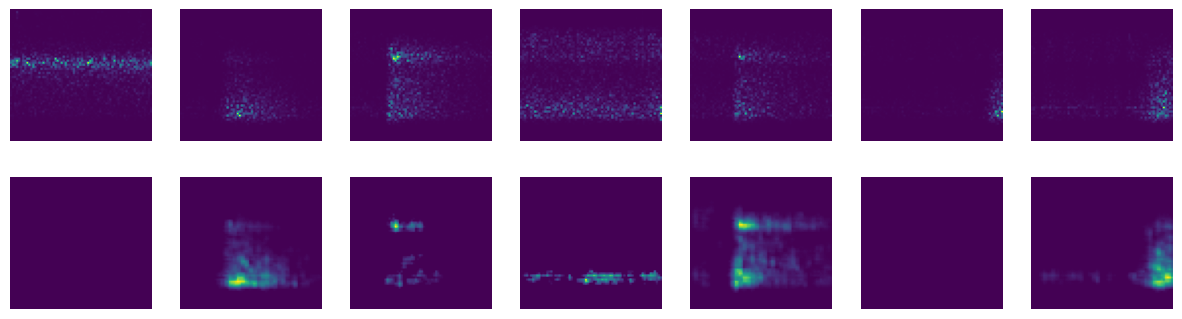

In [19]:
with torch.no_grad():
    for data in autoencoder_loader:
        data = data[0].reshape(-1, 1, height, width).to(device)
        recon = model(data)
        break

import matplotlib.pyplot as plt

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis("OFF")
    ax[1, i].axis("OFF")
plt.show()

tensor(True)


<Figure size 1000x400 with 0 Axes>

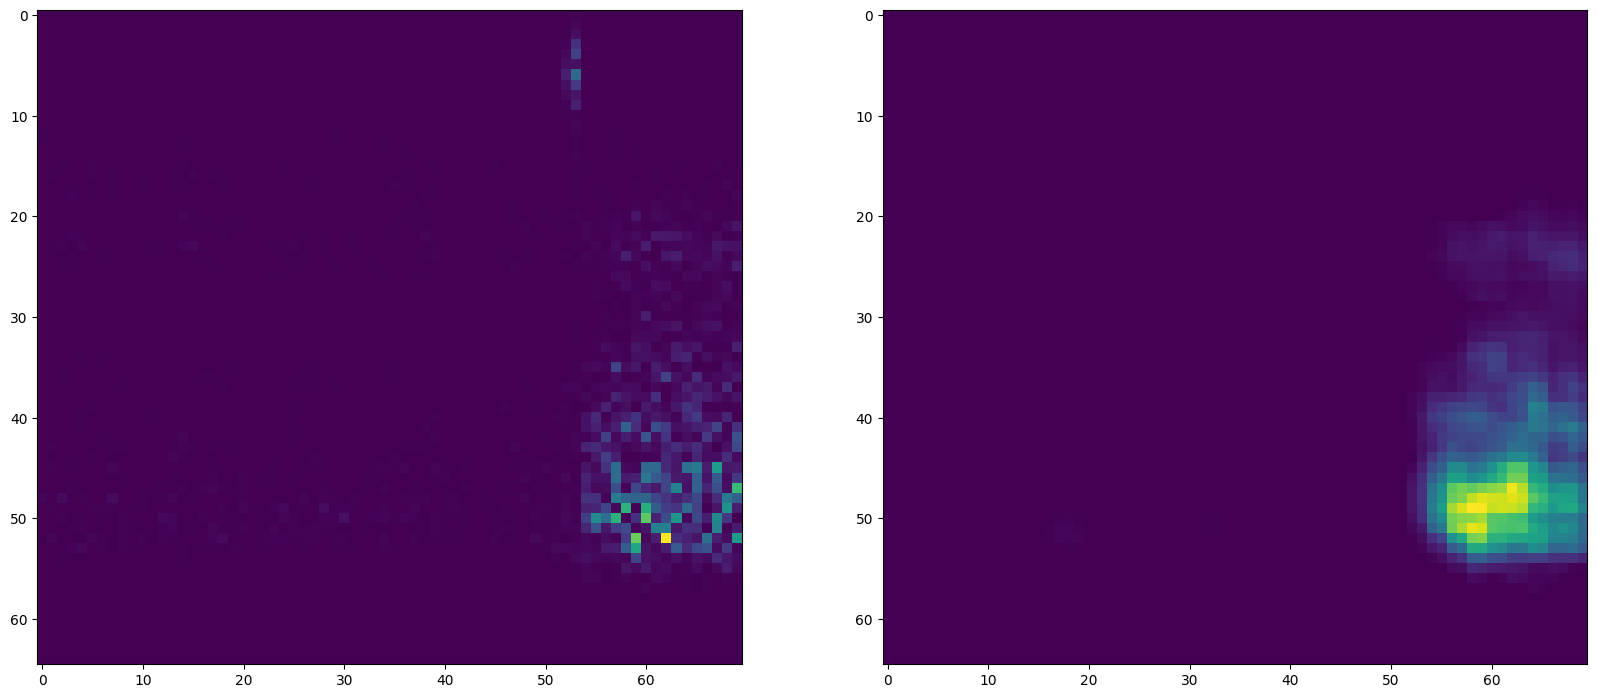

In [22]:
plt.figure(figsize=(10, 4))
model.eval()
with torch.no_grad():
    x_data = next(iter(autoencoder_loader))
    print(x_data[1][0])
    x_data = x_data[0].reshape(-1, 1, height, width).to(device)
    output = model(x_data)
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(x_data[0].cpu().numpy().squeeze())
    ax[1].imshow(output[0].cpu().numpy().squeeze())

In [23]:
# model.save_encoder('./models/encoder.pth')